




--------
James Bay Coordinates
53°30′N 80°30′W



-------

TODO :

    - 



In [14]:

# Data related libraries
import numpy as np
import netCDF4 as nc
import glob
import os

# Plotting related libraries
import matplotlib
#%matplotlib nbagg    # for interactive ploting
import matplotlib.pyplot as plt
# import seaborn as sns 
# sns.set()                
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# Project custom made libaries
import anha4_utils as au


# Machine specific libraries
from sys import platform


In [2]:
#Setting up machine specific path

def get_paths():

    if platform == "linux" or platform == "linux2":
        # linux

        # setup paths
        mask_path = '/mnt/storage0/jmarson/ANALYSES/MASKS/'
        data_path = '/mnt/storage0/jmarson/NEMO/ANHA4/ANHA4-EPM111-S/'

    elif platform == "darwin":
        # OS X

        # setup paths
        data_path = '/Users/jeenriquez/Documents/CEOS/ANHA4/Test_Data/'
        mask_path = '/Users/jeenriquez/Documents/CEOS/ANHA4/Test_Data/'        

    return data_path,mask_path
        
    
data_path,mask_path = get_paths()

# Get complete file list from path
file_list = os.listdir(data_path)




# File selection given platform and other parameters
if platform == "linux" or platform == "linux2":
    
    #Set data list params
    year= '1958'
    grid = 'T'
    month_list = ['04','05','06','07','08','09','10','11','12']

    #selecting list of files given params
    file_list = sorted([ f for f in file_list if 'y'+year in f and 'grid'+grid in f])

    new_file_list =[]
    
    for month in month_list:
        file_name_stump = 'y{}m{}'.format(year,month)
        file_month_name = [ f for f in file_list if file_name_stump in f ][0]
        new_file_list.append(file_month_name)
    
    file_list = new_file_list
    
elif platform == "darwin":

    #Set data list params
    year= '1998'
    grid = 'T'
    month_list = ['04','06','08']
    
    # Selecting list of files given params
    file_list = sorted([ f for f in file_list if 'y'+year in f and 'grid'+grid in f])


# Adding full path to filenames
file_list = [data_path+filename for filename in file_list]



In [3]:
# Setting up model parameters based on Hudson Bay and James Bay locations. 
            
Hudson_bay = True           # Boolean if using Hudson Bay vs James Bay locations.
depth = 0                    # z axis location from 50 unit "depth" 

if Hudson_bay: 
    x_range = (330,500)      # x axis range related to Longitude range for Hudson Bay
    y_range = (20,120)       # y axis range related to Latitude range for Hudson Bay
    
    proj_size = 2
    region = 'HudsonBay'
    
else:
    x_range = (335,390)      # x axis range related to Longitude range for James Bay 
    y_range = (55,105)       # y axis range related to Latitude range for James Bay
    
    proj_size = 4
    region = 'JamesBay'
    

In [8]:
# Reading ANHA4 mask data
mask = nc.Dataset(mask_path+"ANHA4_mask.nc")

# Extracting mask data for given depth
tmask = mask['tmask'][0][depth]

# Creating mask frame to use in given location. 
surf_mask = np.zeros(np.shape(tmask))

# Populating mask array with nan values where there is ocean model data, to effectively mask the surface.
for i in range(x_range[0], x_range[1]):
    for j in range(y_range[0], y_range[1]):
        if tmask[i][j] == 1.:
            surf_mask[i][j] = np.nan

# Extract selected region.            
surf_mask = surf_mask[x_range[0]:x_range[1],y_range[0]:y_range[1]]


In [7]:
# Reading lat and long


def get_lat_lon(data,x_range,y_range):
    """  Getting Latitude and Longitude """
    
    lat = data['nav_lat_grid_T'][x_range[0]:x_range[1],y_range[0]:y_range[1]]
    lon = data['nav_lon_grid_T'][x_range[0]:x_range[1],y_range[0]:y_range[1]]
    
    return lat,lon

def get_mask(x_range,y_range,depth):
    """  Getting Mask given Latitude and Longitude """
 
    # Reading ANHA4 mask data
    mask = nc.Dataset(mask_path+"ANHA4_mask.nc")

    # Extracting mask data for given depth
    tmask = mask['tmask'][0][depth]
    
    surf_mask = tmask[x_range[0]:x_range[1],y_range[0]:y_range[1]]
    
    return surf_mask





In [6]:


def get_lat_lon_grids(lat,lon):
    """Setting up lat-lon grid"""

    # Checking values from the whole region, not just the axis
    max_lat = lat.data[lat.data!=0].max()
    min_lat = lat.data[lat.data!=0].min()
    max_lon = lon.data[lon.data!=0].max()
    min_lon = lon.data[lon.data!=0].min()

    lon_levels = int(abs( max_lon - min_lon ))
    lat_levels = int(abs( max_lat - min_lat ))   

    lat_grid_values = np.arange(int(np.ceil(min_lat)),int(np.ceil(max_lat)))
    lon_grid_values = np.arange(int(np.ceil(min_lon)),int(np.ceil(max_lon)))

        #EE this is not correct, since values are taken from mask.
    aspect_ratio = (max_lat-min_lat) / (max_lon-min_lon)

    
    return lat_grid_values,lon_grid_values,aspect_ratio
    
    
def find_nearest_index(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

def get_lat_lon_ticks(lat,lon):
    """Setting up lat long tick marks"""
    
    # Lat Lon boundary on axis 
    max_lat = lat[:,0][lat[:,0] !=0].max()
    min_lat = lat[:,0][lat[:,0] !=0].min()
    max_lon = lon[0,:][lon[0,:] !=0].max()
    min_lon = lon[0,:][lon[0,:] !=0].min()

#     lon_levels = int(abs( max_lon - min_lon ))
#     lat_levels = int(abs( max_lat - min_lat ))   

    numer_of_ticks = 3

    lat_tick_values = np.arange(int(np.ceil(min_lat)),int(np.ceil(max_lat)),int(max_lat-min_lat)//numer_of_ticks)
    lon_tick_values = np.arange(int(np.ceil(min_lon)),int(np.ceil(max_lon)),int(max_lon-min_lon)//numer_of_ticks)
    
    # Find indices with no zeros 
#     lat_valid_index = lat[:,0].nonzero()[0]
#     lon_valid_index = lon[0,:].nonzero()[0]
    
    # Calculate the tick values 
    lat_tick_indices = np.array([find_nearest_index(lat[:,0],val) for val in list(lat_tick_values) ])
    lon_tick_indices = np.array([find_nearest_index(lon[0,:],val) for val in list(lon_tick_values) ])
#lat_valid_index[0],lat_valid_index[-1],lat_valid_index[-1]//(numer_of_ticks-1))
#lon_valid_index[0],lon_valid_index[-1],lon_valid_index[-1]//(numer_of_ticks-2))
    
    # Degree symbol
    deg = u'\xb0'

    # Simple way to get cardinal locations, assuming all values are in the same cartesian quadrant. 
    if min_lat > 0:
        card_ns = 'N'
    else:
        card_ns = 'S'

    if min_lon > 0:
        card_ew = 'E'
    else:
        card_ew = 'W'

    # Find lat and long values for ticks
    lat_tick_values = [ '%i%s%s'%(ti,deg,card_ns) for ti in list(lat_tick_values)]
    lon_tick_values = [ '%i%s%s'%(ti,deg,card_ew) for ti in list(lon_tick_values)]

    return lat_tick_indices,lon_tick_indices,lat_tick_values,lon_tick_values
    


#### plotting multiple dates

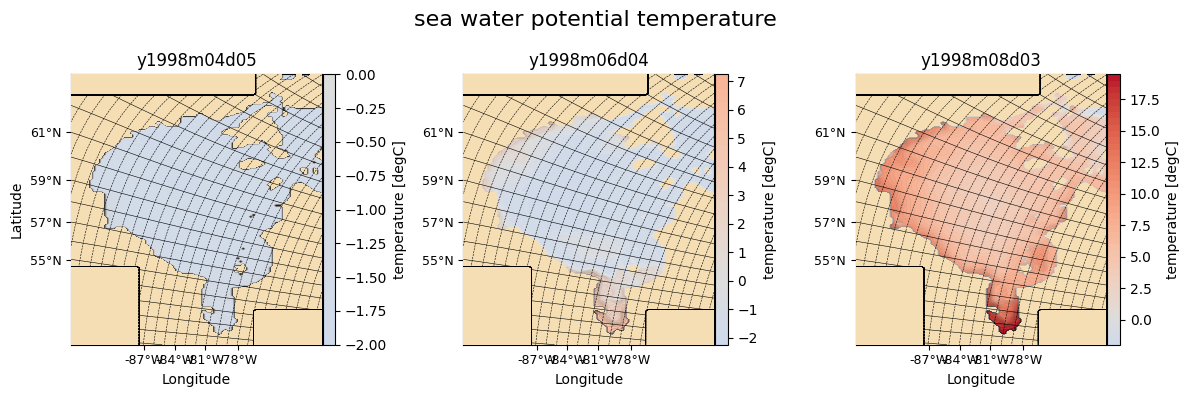

In [11]:

# Setting ploting vars.
levels = 42

vmax=20.
vmin=-20.

# Choosing variable to plot 
var =  'votemper'

# Setting up figure
f_size = 4
ncols = 3
nrows = int(np.ceil(len(file_list)/ncols))
fig, ax = plt.subplots(ncols=ncols,nrows=nrows, figsize=[ncols*f_size,nrows*f_size])

for i, xx in enumerate(fig.axes):
    
    # Stop loop when number of subplots is larger than the number of files. 
    if i == len(file_list):
        break
    
    # Get data
    data = nc.Dataset(file_list[i])
    temp = data[var][:]

    # Cut data
    temp = temp[0,depth,x_range[0]:x_range[1],y_range[0]:y_range[1]]
    
    #getting lat and lon 
    if i == 0:
        lat, lon = get_lat_lon(data,x_range,y_range)    
        lat_grid_values,lon_grid_values,aspect_ratio = get_lat_lon_grids(lat,lon)
        lat_tick_indices,lon_tick_indices,lat_tick_values,lon_tick_values = get_lat_lon_ticks(lat,lon)
    
    # Plotting data
    #plotting filled countour regions 
    im = xx.contourf(temp,levels=levels,cmap='coolwarm',vmin=vmin,vmax=vmax)

    # Plotting data countor lines
    xx.contour(temp,levels=levels,cmap='Greys',linewidths=.1)
    #plt.contour(test_var[0,depth,x_range,20:120],levels=levels,cmap='Greys',linewidths=.2,vmin=vmin,vmax=vmax)
    #plt.colorbar()

    # Surface mask.
    xx.contourf(surf_mask, colors= 'wheat', zorder = 3)

    # Plotting lat lon contour lines
#     xx.contour(lat,levels=lat_levels*proj_size,cmap='binary',vmin=min_lat,vmax=max_lat,linewidths=.2, zorder = 3)
#     xx.contour(lon,levels=lon_levels*proj_size,cmap='binary',vmin=min_lon,vmax=max_lon,linewidths=.2, zorder = 3)
    #EE: giving array of whole degree values.
    xx.contour(lat,levels=lat_grid_values,colors='k',linewidths=.4, zorder = 3)
    xx.contour(lon,levels=lon_grid_values,colors='k',linewidths=.4, zorder = 3)
    
    
    # Set axis labels
    xx.set_xlabel('Longitude')
    if i % ncols == 0:
        xx.set_ylabel('Latitude')

    # Set title
    #plt.title(data.variables['votemper'].standard_name)
    xx.set_title(file_list[i].split('/')[-1].split('_')[1])
    
    # Set tick marks
    xx.set_yticks(ticks = lat_tick_indices , labels= lat_tick_values, fontsize = 9)    
    xx.set_xticks(ticks = lon_tick_indices , labels= lon_tick_values, fontsize = 9)
      
    # Set Colorbar
    divider = make_axes_locatable(xx)
    cax = divider.append_axes('right', size='5%', pad=0.01)
    label = data.variables[var].long_name+' ['+data.variables[var].units+']'
    fig.colorbar(im, cax=cax, orientation='vertical',label=label)

fig.suptitle(data.variables[var].standard_name.replace('_',' '), fontsize=16)
fig.tight_layout()

#Save figure to file.
if platform == "linux" or platform == "linux2":
    plt.savefig('../figs/%s_%s_y%s_m%s-%s.png'%(region,data.variables[var].long_name,year,month_list[0],month_list[-1]))


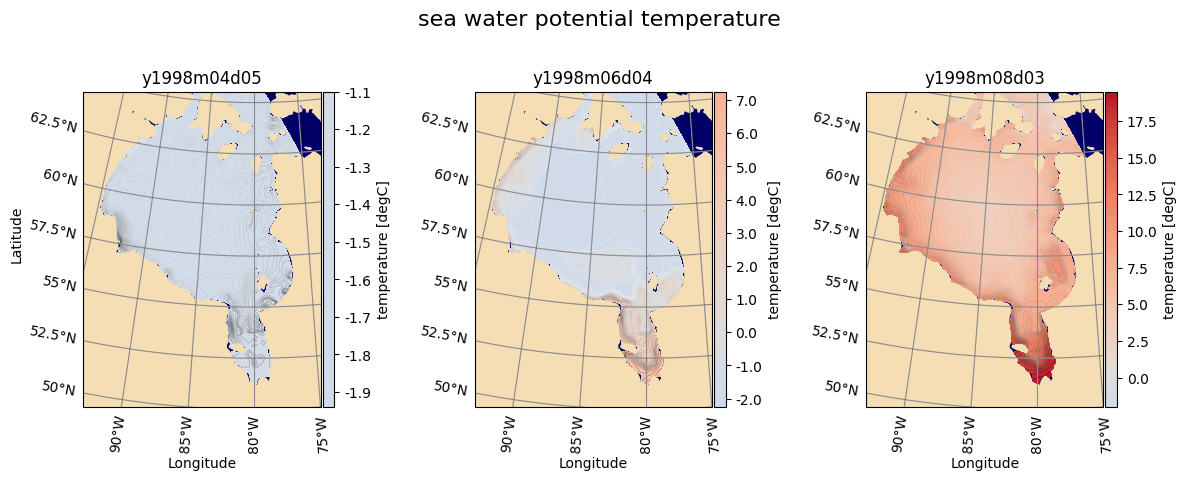

In [15]:
# Setting ploting vars.
levels = 42

vmax=20.
vmin=-20.

# Choosing variable to plot 
var =  'votemper'

# An arbitrary choice.
hudson_east = -75
hudson_west = -93
hudson_north = 65
hudson_south = 50

standard_parallels = (52.5,62.5)
central_longitude = -80

# Setting up figure
f_size = 4
ncols = 3
nrows = int(np.ceil(len(file_list)/ncols))
fig, ax = plt.subplots(ncols=ncols,nrows=nrows, figsize=[ncols*f_size,nrows*f_size+1],
                     subplot_kw={'projection':ccrs.LambertConformal(central_longitude=central_longitude,
                                                      standard_parallels=standard_parallels)})

# Looping over files
for i, xx in enumerate(fig.axes):
    
    # Stop loop when number of subplots is larger than the number of files. 
    if i == len(file_list):
        break
    
    xx.set_extent([hudson_west, hudson_east, hudson_south, hudson_north])

    #ax.stock_img()
    #ax.coastlines()
    xx.gridlines()
    xx.add_feature(cartopy.feature.OCEAN, facecolor='#000066')
    xx.add_feature(cartopy.feature.LAND, facecolor=matplotlib.colors.to_hex('wheat'))# '#009900')
#    xx.add_feature(cartopy.feature.LAND, facecolor=cartopy.feature.COLORS['land_alt1'])

    # Get data
    data = nc.Dataset(file_list[i])
    temp = data[var][:]

    # Cut data
    temp = temp[0,depth,x_range[0]:x_range[1],y_range[0]:y_range[1]]
    
    # Get mask
    surf_mask = get_mask(x_range,y_range,depth)

    # Remove zero values in mask region
    temp.data[~np.ma.filled((1 == surf_mask.data))] = np.nan
    
    #getting lat and lon 
    if i == 0:
        lat, lon = get_lat_lon(data,x_range,y_range)    

    # Plotting data
    # Plotting filled countour regions 
    im = xx.contourf(lon,lat,temp,levels=levels,cmap='coolwarm',vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
    # Plotting data countor lines
    xx.contour(lon,lat,temp,levels=levels,cmap='Greys',linewidths=.2,transform=ccrs.PlateCarree())

    # Set gridline labels
    gl = xx.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False,
                      color='k',alpha=.2,linewidths=.01) 
    gl.right_labels = gl.top_labels = False
    gl.fontsize = 50
    
    # Set axis labels
    if i > ncols*(nrows-1)-1:
        xx.text(0.5, -0.22, 'Longitude', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=xx.transAxes)
    if i % ncols == 0:
        xx.text(-0.25, 0.55, 'Latitude', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=xx.transAxes)
    
    # Set title
    xx.set_title(file_list[i].split('/')[-1].split('_')[1])        
    
    # Set Colorbar
    axins = inset_axes(xx, width="5%", height="100%",loc='right',borderpad=-1)
    label = data.variables[var].long_name+' ['+data.variables[var].units+']'
    fig.colorbar(im, cax=axins, orientation="vertical",label=label,format='%.1f')

    
if len(fig.axes) == 18:
    hspace = .27
else:
    hspace = .1
    
    
fig.suptitle(data.variables[var].standard_name.replace('_',' '),fontsize=16)
fig.subplots_adjust(bottom=0.1,top=0.9,left=0.07,right=.92,wspace=.65,hspace=hspace)

#Save figure to file.
# if platform == "linux" or platform == "linux2":    
#     output_fig_name = '../figs/%s_%s_y%s_m%s-%s.png'%(region,data.variables[var].long_name,year,month_list[0],month_list[-1])
#     plt.savefig(output_fig_name, bbox_inches='tight',dpi=500)


In [ ]:
nrows


In [ ]:
# Sandbox for playing around  with multiple options on projections and masking. Most options here don't seem to work.

# Setting ploting vars.
levels = 42

vmax=20.
vmin=-20.

# Choosing variable to plot 
var =  'votemper'

# An arbitrary choice.
hudson_east = -75
hudson_west = -93
hudson_north = 65
hudson_south = 50

standard_parallels = (55,60)
central_longitude = -80

fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)

ax = fig.add_subplot(1, 1, 1,
                     projection=ccrs.LambertConformal(central_longitude=central_longitude,
                                                      standard_parallels=standard_parallels))
ax.set_extent([hudson_west, hudson_east, hudson_south, hudson_north])

#ax.stock_img()
#ax.coastlines()
ax.gridlines()
ax.add_feature(cartopy.feature.OCEAN, facecolor='#000066')
ax.add_feature(cartopy.feature.LAND, facecolor='#009900')

i=0

# Get data
data = nc.Dataset(file_list[i])
temp = data[var][:]

# Cut data
temp = temp[0,depth,x_range[0]:x_range[1],y_range[0]:y_range[1]]

#temp[np.where(temp<=0)] = np.nan

#temp = np.ma.array(temp , mask=temp.mask | np.where(temp.data == 0.),fill_value=100)
#temp = np.ma.array(np.where(~temp.mask,temp,np.nan) , mask=temp.mask,fill_value=100)
#temp.mask = ~temp.mask



surf_mask2 = get_mask(x_range,y_range,depth)

#This works
temp.data[~np.ma.filled((1 == surf_mask2.data))] = np.nan

#surf_mask3 = np.ma.masked_array(np.where(~temp.mask,temp.data,np.nan), mask=temp.mask, fill_value=0)
#surf_mask3 = np.ma.masked_array(np.where(temp.mask,temp.data,np.nan), mask=~temp.mask, fill_value=0)
#surf_mask3 = np.ma.masked_array(np.where(temp.mask ,10,np.nan), mask=~temp.mask, fill_value=1e8)
#surf_mask2.data[np.where(surf_mask2.data<=0)] = np.nan
#This works
surf_mask2.data[np.ma.filled((1 == surf_mask2.data))] = np.nan

                
#getting lat and lon 
lat, lon = get_lat_lon(data,x_range,y_range)    


#lon.data[np.ma.filled((0 == lon.data))] = np.nan
#lat.data[np.ma.filled((0 == lat.data))] = np.nan
#lon.data[np.ma.filled((1 == surf_mask2.data))] = np.nan
#lat.data[np.ma.filled((1 == surf_mask2.data))] = np.nan



# lon_m = np.ma.masked_array(lon,mask=~temp.mask)
# lat_m = np.ma.masked_array(lat,mask=~temp.mask)
lon_m = np.ma.masked_array(lon.copy(),mask=~np.ma.filled((0 == surf_mask2.data)))
lat_m = np.ma.masked_array(lat.copy(),mask=~np.ma.filled((0 == surf_mask2.data)))
lon_m.data[np.ma.filled((0 == lon_m.data))] = np.nan
lat_m.data[np.ma.filled((0 == lat_m.data))] = np.nan


#lon.data[np.ma.filled((1 == surf_mask2.data))] = np.nan


# Plotting data
#plotting filled countour regions 
im = ax.contourf(lon,lat,temp,levels=levels,cmap='coolwarm',vmin=vmin,vmax=vmax,transform=ccrs.PlateCarree())
#im = ax.contourf(lon,lat,temp,levels=levels,cmap='viridis',vmin=vmin,vmax=vmax)
#im = ax.contourf(temp.data,levels=levels,cmap='coolwarm',vmin=vmin,vmax=vmax)
#im = ax.contourf(temp, cmap= 'coolwarm')
#im = ax.imshow(temp, cmap= 'coolwarm')



# Plotting data countor lines
#ax.contour(lon,lat,temp,levels=levels,cmap='Greys',linewidths=.2,transform=ccrs.PlateCarree())

# Surface mask.
#ax.contourf(lon,lat,surf_mask2, colors= 'wheat',transform=ccrs.PlateCarree(), zorder = 3)
#ax.contourf(lon_m,lat_m,surf_mask2, colors= 'k', zorder = 3)
#ax.contourf(lon,lat,surf_mask, colors= 'wheat', zorder = 3)
#ax.contourf(surf_mask2, cmap= 'viridis',zorder=3)
#ax.contourf(surf_mask2, cmap= 'Greens',zorder=3)
#ax.contourf(lat_m, cmap= 'viridis',zorder=3)
#ax.imshow(surf_mask2, cmap= 'viridis',zorder=3)


#gridline labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, x_inline=False, y_inline=False,color='w',alpha=1.,linewidths=.05, zorder = 5) 
gl.right_labels = gl.top_labels = False

# Set Colorbar
axins = inset_axes(ax, width="5%", height="100%",loc='right',borderpad=-2)
label = data.variables[var].long_name+' ['+data.variables[var].units+']'
fig.colorbar(im, cax=axins, orientation="vertical",label=label)



#EE: lo que no esta funcionando en lon lan. Necesito ver que pedo con sus masks. 
# cambie los valores donde salen zeros, pero creo que tengo que "Activar" el mask array.
# Si puedo quitar la "mascara" de temp, y poner LAND, pero quedan guecos, y no se ve tan bien. 
# maybe good enough for now? 
# I think what I need is a different lon-lat pair for temp and mask.

#It seems to me now that the issue is with the countours and the interpolation is using. 
#Because now I'm giving some edges to the data.
# Yep, imshow shows to be different than contourf... 


In [ ]:
# Little test to compare contourf and imshow


# Get data
data = nc.Dataset(file_list[2])
temp = data[var][:]

# Cut data
temp = temp[0,depth,x_range[0]:x_range[1],y_range[0]:y_range[1]]
surf_mask2 = get_mask(x_range,y_range,depth)

# figure stuff
fig, ax = plt.subplots(ncols=3,nrows=1)

ax[0].contourf(surf_mask2)
ax[0].contourf(temp)

ax[1].contourf(surf_mask2,levels=20)
ax[1].contourf(temp,levels=100)

ax[2].imshow(np.flipud(surf_mask2))
ax[2].imshow(np.flipud(temp))
